<a href="https://colab.research.google.com/github/tuphr2234/ChaosPredition/blob/main/ThreeBodySimulation_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build Simulation

In [73]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf
import os
from pathlib import Path  


G=1


class Body:
  
  prevPosition=np.array([0,0])
  position=np.array([0,0])
  velocity=np.array([0,0])
  force=np.array([0,0])
  acceleration=np.array([0,0])
  mass=0

  def __init__(self,position,velocity,mass,name):
    self.position=np.array(position)
    self.velocity=np.array(velocity)
    #self.acceleration=np.array(acceleration)
    self.mass=mass
    self.prevPosition=np.array(position)
    self.name = name


#  def __init__(self,position,mass):
#    self.position=np.array(position)
#    self.prevPosition=np.array(position)
#    self.mass = mass
    


 # def __init__(self):
   #     pass


  def setInitialPostion(self,position):
    self.postion = np.array(position)

    
  def setInitialVelocity(self,velocity):
    self.velocity = np.array(velocity)

   
  def setInitialMass(self,mass):
    self.mass = mass




  def setPosition(self,t):
    self.prevPosition = self.position
    self.position=self.position+self.velocity*t+(self.acceleration/2)* t**2
  

  def setVelocity(self,t):
    self.velocity=self.velocity+self.acceleration*t
  

  def getForce(self,body):
    softening = 0.0000000000000001
    Distance = body.prevPosition - self.position
    Rsquare = Distance[0]**2 + Distance[1]**2 + softening
    F = G* self.mass*body.mass / Rsquare  
    normalizeDis = Distance / math.sqrt(Rsquare)
    F = F*normalizeDis
    
    #print(f"body {self.name} force is {F} ")
    
    return F

  def setAcceleration(self,bodies):
    F=np.array([0,0])
    for body in bodies:
      F=F+self.getForce(body)
    self.acceleration = F/self.mass
   # print(f" {self.name} acceleration is {self.acceleration}")

In [13]:


def simulateOnTimeStep(bodies,t,steps,interval_in_data): # bodies: list of bodies. t: timestep . steps: number of steps. interval_in_data : frequency of rows taken to dataset: if equals 1 than it is every step
  dataset = []
  time = []

  for i in range(steps):
      list1=[]
      for body in bodies:
        list1.append(body.position)
      if i % interval_in_data ==0:
        dataset += list1
        time.append(i * t)
      
      for i,body in enumerate(bodies):
        body.setAcceleration([b for b in bodies if b is not body])
        body.setVelocity(t)
        body.setPosition(t)
       
        
      for body in bodies:
        #plt.plot([body.prevPosition[0],body.position[0]],[body.prevPosition[1],body.position[1]])
        body.prevPosition = body.position
  #plt.show()
    

  return np.array(dataset).reshape(steps//interval_in_data,len(bodies),2),time



In [14]:
def numpyToPandas(simulation,numOfBodies):
  columns = []

  for i in range(numOfBodies):
    columns.append(f'Body{i+1} x')
    columns.append(f'Body{i+1} y')
  simulation_reshaped = simulation.reshape(len(simulation), numOfBodies*2 )

  df = pd.DataFrame(simulation_reshaped, columns = columns)
  return df


Add Filters

In [15]:
#def addNoise(simulation):
#def removeBody(simulation)

Save Simulation

In [16]:
## save simulation as csv
def saveSimulation(simulation,numOfBodies,simulation_name):
  df = numpyToPandas(simulation,numOfBodies) 
  df.to_csv(f'/content/{simulation_name}.csv',index=False)
  
def loadSimulation(df):
  return pd.DataFrame.to_numpy(df)  

Prepare Dataset 

In [17]:
def prepareData(simulation,window_size_X):
  X = []
  y = []
  for i in range(len(simulation)-window_size_X):
    row = [bodies for bodies in simulation[i:i+window_size_X]]  ### adding time is an option
    X.append(row)
    label = simulation[i+window_size_X]
    y.append(label)
  return np.array(X) , np.array(y)  

In [18]:
def prepareData2(simulation,window_size_X,window_size_y): 
  X = []
  y = []
  for i in range(len(simulation)-window_size_X - window_size_y):
    row = [bodies for bodies in simulation[i:i+window_size_X]]  
    X.append(row)
    label =  [bodies for bodies in simulation[i+window_size_X:i+window_size_X + window_size_y]]#######################################
    y.append(label)

  return np.array(X) , np.array(y)


In [19]:
def splitToTrainValidTest(dataset,testPercentage):
  trainLen = round((len(dataset)*(1-testPercentage-0.05)))
  valLen = round((len(dataset)*0.05))
  train_set = dataset[:trainLen]
  val_set = dataset[trainLen:trainLen+valLen]
  test_set = dataset[trainLen+valLen:]
  return train_set,val_set,test_set

In [20]:
def drawSimulation(simulation):
  prev = np.copy(simulation[0])
  numOfBodies = len(simulation[0])
  colors = ['red','green','blue','yellow','black']
  for i,sim in enumerate(simulation):
    if i == 0:
      continue
    for j in range(0,len(sim),2):
      plt.plot([prev[j],sim[j]],[prev[j+1],sim[j+1]],  color = colors[j // 2])
      prev[j] = np.copy(sim[j])
      prev[j+1] = np.copy(sim[j+1])
  plt.show()


In [22]:
def showBodiesMovmentInGraph(simulation):

  for i in range(0,len(simulation.columns),2):
      df = simulation.iloc[:,i]
      plt.plot(df)
  plt.show()

  for i in range(1,len(simulation.columns),2):
      df = simulation.iloc[:,i]
      plt.plot(df)
  plt.show()




Preprocessing/Postprocessing

Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
def buildModelCNN(window_size_X,numberOfBodies): ### One step at a time - autoreggresive model 
  model = Sequential()
  model.add(InputLayer((window_size_X,numberOfBodies*2)))#model.add(InputLayer((window_size_X,numberOfBodies*2)))
  model.add(Conv1D(64, kernel_size=2))
  #model.add(Dropout(0.2))
  model.add(Conv1D(32, kernel_size=2))
  #model.add(TimeDistributed(conv_1d))
  model.add(Flatten())
  #model.add(LSTM(32))
  #model.add(Dropout(0.2))
  model.add(Dense(16, 'relu'))
  model.add(Dense(numberOfBodies*2, 'linear'))
  model.summary()
  return model



def buildModelCNN2(window_size_X,window_size_y,numberOfBodies): ### Multiple predictions at a time
  model = Sequential()
  model.add(InputLayer((window_size_X,numberOfBodies*2)))#model.add(InputLayer((window_size_X,numberOfBodies*2)))
  #model.add(Conv1D(64, kernel_size=2)) ###
  #model.add(Dropout(0.2))
  model.add(Conv1D(32, kernel_size=2)) ###
  #model.add(TimeDistributed(conv_1d))
  model.add(Flatten())
  #model.add(LSTM(32))
  #model.add(Dropout(0.2))
  model.add(Dense(16, 'relu'))
  model.add(Dense(units =  window_size_y*numberOfBodies*2, activation ='linear'))
  model.add(tf.keras.layers.Reshape([window_size_y, numberOfBodies*2]))
  model.summary()
  return model

In [24]:
def preprocessSimulation(simulation):
  shape = simulation[0].shape
  newSimulation = np.append(simulation[1:],[np.zeros(shape)],axis=0) - simulation
  newSimulation = newSimulation[:-1]
  #for i,s in enumerate(newSimulation):
  #  s = s / np.linalg.norm(simulation[i])
  return newSimulation

In [25]:
def postprocess(lastKnownElement , listOfPredictedChanges):
  listOfPredictions = []
  for pred in listOfPredictedChanges:
    #newElement = (pred * np.linalg.norm(lastKnownElement)) + lastKnownElement
    newElement = pred  + lastKnownElement
    listOfPredictions.append(newElement)
    lastKnownElement = newElement
  return np.array(listOfPredictions)  


Find a random chaotic simulation 

In [26]:
import random

def generateRandomInitials(bodies):

   randomMass = random.uniform(-1,1)
   for body in bodies:
     body.setInitialVelocity([random.uniform(-1,1),random.uniform(-1,1)])
     #body.setInitialPostion([random.uniform(-1,1),random.uniform(-1,1)])
     body.setInitialMass(1)


   return bodies

##t: timestep . steps: number of steps. interval_in_data
timestep = 0.001 # actual seconds
steps = 122000
interval_in_data = 10

bodies=[]
bodies.append(Body([-0.97000436, 0.24308753],1))
bodies.append(Body([0,0],1))
bodies.append(Body([-0.97000436, 0.24308753],1))




while True:
  generateRandomInitials(bodies)
  randSimulation,_ = simulateOnTimeStep(bodies,timestep,steps,interval_in_data)
  randSimulation=randSimulation.reshape(len(randSimulation), 3*2 )

  if(np.linalg.norm(randSimulation[0][0]-randSimulation[len(randSimulation)//2][0])<50):
    saveSimulation(randSimulation,3,"chaotic simulation")
    break
  else:
    print(np.linalg.norm(randSimulation[0]-randSimulation[len(randSimulation)//3]))

Training Model

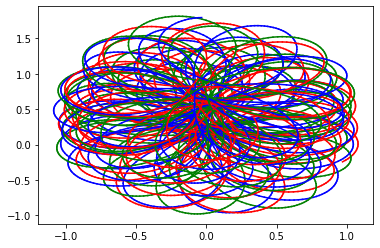

In [131]:
#position,velocity,mass
#%%timeit
divFactor = 100
bodies=[]
bodies.append(Body([0.97000436,-0.24308753],[0.466203685,0.45236573],1,"body1"))
bodies.append(Body([-0.97000436,0.24308753],[0.466203685,0.41236573],1,"body2"))
bodies.append(Body([0, 0],[-0.93240737,-0.84473146],1,"body3"))
#bodies.append(Body([2, 0.24308753],[-0.4662036850, 0.2323657300],1,"body4"))

 #r1(0) = −r3(0) = (−0.97000436, 0.24308753);
 # r2(0) = (0,0); v1(0) = v3(0) = (0.4662036850, 0.4323657300);
 # v2(0) = (−0.93240737, −0.86473146). The values are obtained from Chenciner & Montgomery (2000).

numOfBodies=len(bodies)
##t: timestep . steps: number of steps. interval_in_data
timestep = 0.0001 # actual seconds
steps = 1220000
interval_in_data = 500

simulation1,timesteps = simulateOnTimeStep(bodies,timestep,steps,interval_in_data)
simulation1=simulation1.reshape(len(simulation1), numOfBodies*2 )
saveSimulation(simulation1,numOfBodies,"N-Body Simulation")
drawSimulation(simulation1)

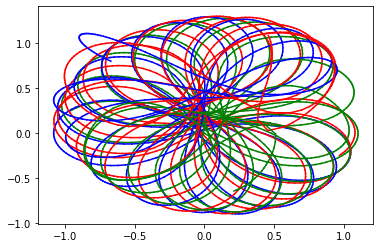

In [120]:
drawSimulation(simulation1[0:1250])

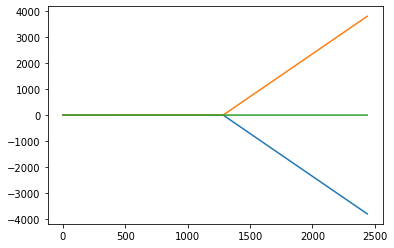

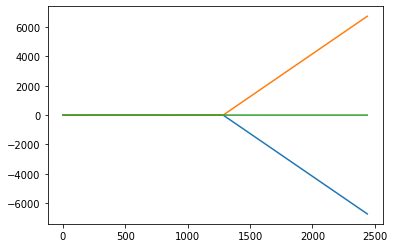

In [119]:
showBodiesMovmentInGraph(numpyToPandas(simulation1,numOfBodies))

In [106]:
simulation1 = loadSimulation(pd.read_csv('/content/N-Body Simulation.csv'))

In [107]:
numOfBodies = simulation1.shape[1] // 2

In [132]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.signal import hilbert
scaled = False 

batch = 128

diffSimulation1 = np.diff(simulation1,axis = 0)
#diffSimulation1 = np.diff(simulation1[:1090],axis = 0)
train, val, test = splitToTrainValidTest(diffSimulation1,0.2)


windowSizeX=50
windowSizeY =100




if scaled:
  scaler = StandardScaler()
  scaler.fit(simulation1[:len(train)+len(val)])
  #valScaler.fit(train)  ### train / val as input ? 

  train = scaler.transform(train)
  val = scaler.transform(val)
  #train = hilbert(train)
  #val = hilbert(val)
#y_train = scaler.fit(train)

#train = preprocessSimulation(train)
#val = preprocessSimulation(val)



#train2, val2, test2 = splitToTrainValidTest(simulation2,0.2)


#X_train, y_train = prepareData(train,windowSizeX)
#X_val, y_val = prepareData(val,windowSizeX)
#X_test, y_test = prepareData(test,windowSizeX)


X_train, y_train = prepareData2(train,windowSizeX,windowSizeY)
X_val, y_val = prepareData2(val,windowSizeX,windowSizeY)
X_test, y_test = prepareData2(test,windowSizeX,windowSizeY)


model =  buildModelCNN2(windowSizeX,windowSizeY,numOfBodies)
cp1 = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])


#X_train2, y_train2 = prepareData(train2,windowSizeX)
#X_val2, y_val2 = prepareData(val2,windowSizeX)
#X_tes2t, y_test2 = prepareData(test2,windowSizeX)

#generator = TimeseriesGenerator(train_scaled,train_scaled,length = len(test),batch_size=batch)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 49, 32)            416       
                                                                 
 flatten_7 (Flatten)         (None, 1568)              0         
                                                                 
 dense_14 (Dense)            (None, 16)                25104     
                                                                 
 dense_15 (Dense)            (None, 600)               10200     
                                                                 
 reshape_7 (Reshape)         (None, 100, 6)            0         
                                                                 
Total params: 35,720
Trainable params: 35,720
Non-trainable params: 0
_________________________________________________________________


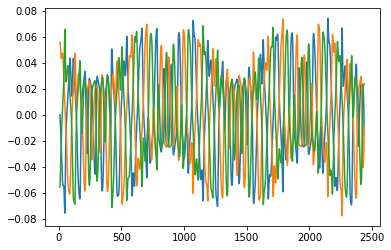

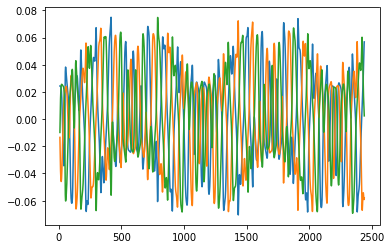

In [134]:
showBodiesMovmentInGraph(numpyToPandas(diffSimulation1[:],numOfBodies)[10:])

In [135]:
#for i in range(100):
  #model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, callbacks=[cp1])
  #model.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=2, callbacks=[cp1])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, callbacks=[cp1])

Epoch 1/15
49/53 [==========================>...] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0317

53/53 [==============================] - 1s 4ms/step - loss: 9.8765e-04 - root_mean_squared_error: 0.0314
Epoch 2/15
39/53 [=====================>........] - ETA: 0s - loss: 4.7652e-04 - root_mean_squared_error: 0.0218

53/53 [==============================] - 0s 3ms/step - loss: 4.2785e-04 - root_mean_squared_error: 0.0207
Epoch 3/15
38/53 [====================>.........] - ETA: 0s - loss: 2.0239e-04 - root_mean_squared_error: 0.0142

53/53 [==============================] - 0s 3ms/step - loss: 1.8539e-04 - root_mean_squared_error: 0.0136
Epoch 4/15
53/53 [==============================] - ETA: 0s - loss: 9.8294e-05 - root_mean_squared_error: 0.0099

53/53 [==============================] - 0s 3ms/step - loss: 9.8294e-05 - root_mean_squared_error: 0.0099
Epoch 5/15
38/53 [====================>.........] - ETA: 0s - loss: 7.3518e-05 - root_mean_squared_error: 0.0086

53/53 [==============================] - 0s 3ms/step - loss: 7.2730e-05 - root_mean_squared_error: 0.0085
Epoch 6/15
47/53 [=========================>....] - ETA: 0s - loss: 6.6648e-05 - root_mean_squared_error: 0.0082

53/53 [==============================] - 0s 6ms/step - loss: 6.6380e-05 - root_mean_squared_error: 0.0081
Epoch 7/15
41/53 [======================>.......] - ETA: 0s - loss: 6.4811e-05 - root_mean_squared_error: 0.0081

53/53 [==============================] - 0s 6ms/step - loss: 6.4779e-05 - root_mean_squared_error: 0.0080
Epoch 8/15
43/53 [=======================>......] - ETA: 0s - loss: 6.3252e-05 - root_mean_squared_error: 0.0080

53/53 [==============================] - 0s 5ms/step - loss: 6.3306e-05 - root_mean_squared_error: 0.0080
Epoch 9/15
51/53 [===========================>..] - ETA: 0s - loss: 6.0717e-05 - root_mean_squared_error: 0.0078

53/53 [==============================] - 0s 5ms/step - loss: 6.0669e-05 - root_mean_squared_error: 0.0078
Epoch 10/15
48/53 [==========================>...] - ETA: 0s - loss: 5.7879e-05 - root_mean_squared_error: 0.0076

53/53 [==============================] - 0s 5ms/step - loss: 5.7956e-05 - root_mean_squared_error: 0.0076
Epoch 11/15
44/53 [=======================>......] - ETA: 0s - loss: 5.4898e-05 - root_mean_squared_error: 0.0074

53/53 [==============================] - 0s 5ms/step - loss: 5.4780e-05 - root_mean_squared_error: 0.0074
Epoch 12/15
45/53 [========================>.....] - ETA: 0s - loss: 5.3703e-05 - root_mean_squared_error: 0.0073

53/53 [==============================] - 0s 5ms/step - loss: 5.3302e-05 - root_mean_squared_error: 0.0073
Epoch 13/15
52/53 [============================>.] - ETA: 0s - loss: 5.0196e-05 - root_mean_squared_error: 0.0071

53/53 [==============================] - 0s 6ms/step - loss: 5.0216e-05 - root_mean_squared_error: 0.0071
Epoch 14/15
44/53 [=======================>......] - ETA: 0s - loss: 4.8969e-05 - root_mean_squared_error: 0.0070

53/53 [==============================] - 0s 4ms/step - loss: 4.8928e-05 - root_mean_squared_error: 0.0070
Epoch 15/15
53/53 [==============================] - ETA: 0s - loss: 4.6395e-05 - root_mean_squared_error: 0.0068

53/53 [==============================] - 0s 6ms/step - loss: 4.6395e-05 - root_mean_squared_error: 0.0068


KeyError: ignored

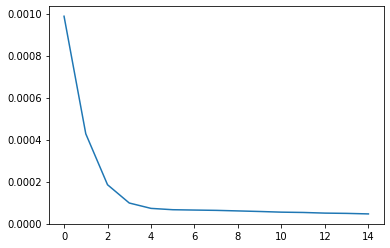

In [136]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#history = model.fit_generator(generator,epochs=100,verbose=1)

Predictions

In [137]:
from sklearn.metrics import mean_squared_error

In [ ]:
predictions = model.predict(X_test)          ###############  LOCAL RMSE  (prediction per window on test set)
#predictions = postprocess(val[-1],predictions)
#predictions = scaler.inverse_transform(predictions)
#print(math.sqrt(mean_squared_error(y_test,predictions)))
print(math.sqrt(mean_squared_error(y_test.reshape(len(X_test),windowSizeY*numOfBodies*2),predictions.reshape(len(X_test),windowSizeY*numOfBodies*2))))


In [138]:
predictions = model.predict(X_train[-1:])
predictions=predictions.squeeze()
predictions.shape
#print(math.sqrt(mean_squared_error(predictions,val)))


(100, 6)

In [ ]:
def slidingWindowActualPredictions(model,windowArr,windowSize,NumOfBodies,predictionsRequestedNumber): ### One step at a time autoregresion
  

  actualPredictionArr =[]
  for i in range(predictionsRequestedNumber):

    prediction = model.predict(windowArr[-1:]) ### predict from last window
    actualPredictionArr.append(prediction)
    temp = np.zeros([windowSize,numOfBodies*2])
    temp = temp + windowArr[-1]
    temp =temp[1:]
    newWindow = np.append(temp.reshape(windowSize-1,numOfBodies*2),prediction)
    newWindow = newWindow.reshape(windowSize,numOfBodies*2)
    lengthX = len(windowArr)
    windowArr = np.append(windowArr,newWindow) ### add new window that the last vector is the prediction 
    windowArr = windowArr.reshape(lengthX+1,windowSize,numOfBodies*2)

  return actualPredictionArr

In [ ]:
%%script false

import math

listOfPredictions = slidingWindowActualPredictions(model,X_train,windowSizeX,numOfBodies,len(val)+len(test))
listOfPredictions =np.array(listOfPredictions)
listOfPredictions = listOfPredictions.squeeze()

listOfPredictionsTrue = postprocess(simulation1[len(X_train)+windowSizeX-1],listOfPredictions)

if scaled:
  listOfPredictionsTrue = scaler.inverse_transform(listOfPredictionsTrue)


In [139]:
actualPredictions = postprocess(simulation1[len(X_train)+windowSizeX-1],predictions)

In [ ]:
#print(math.sqrt(mean_squared_error(simulation1[len(X_train)+windowSizeX+1:],listOfPredictionsTrue))) ##### ACTUAL RMSE #####
print(math.sqrt(mean_squared_error(postprocess(simulation1[len(X_train)+windowSizeX-1],val[:100]),actualPredictions))) ##### ACTUAL RMSE #####


In [ ]:
%%script false

print((diffSimulation1[len(X_train)+windowSizeX-1]))

print((train[-1:]))

print(listOfPredictions[0])
if scaled:
  print((scaler.inverse_transform(model.predict(X_train[-1:]))))

In [ ]:
#%%script false

import matplotlib.pyplot as plt
disArr = []
#for i in range(len(val)+len(test)):
  #disArr.append(np.linalg.norm(simulation1[len(X_train)+windowSizeX+i+1]-listOfPredictionsTrue[i]))
for i in range(len(val)):
  disArr.append(np.linalg.norm(postprocess(simulation1[len(X_train)+windowSizeX-1],val)[i]-actualPredictions[i]))

plt.plot(disArr)  

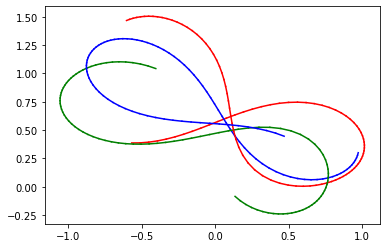

In [140]:
#drawSimulation(simulation1[len(X_train)+windowSizeX+2:len(X_train)+windowSizeX+31])
drawSimulation(simulation1[len(X_train)+windowSizeX+1 : len(X_train)+windowSizeX + 100])

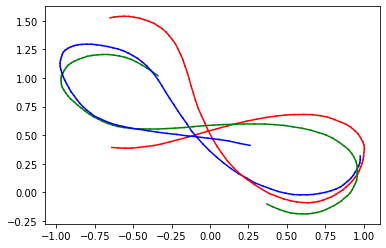

In [141]:
#drawSimulation(listOfPredictionsTrue[1:30])
drawSimulation(actualPredictions)